### Imports

In [1]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from transformer import Transformer

### Artificial Time Series

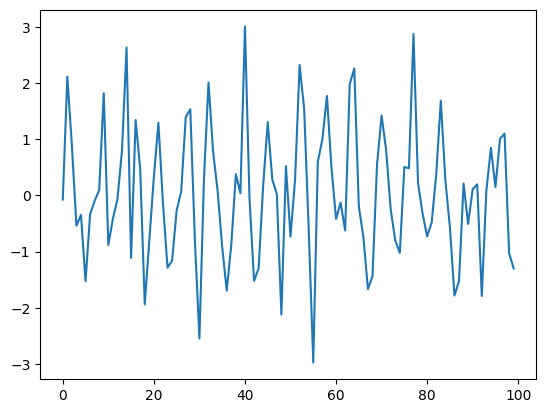

In [8]:
sequence = np.sin(np.arange(0,100,1))+np.random.normal(0,0.8,100)
plt.plot(sequence)
plt.show()

### Test Data Loader

In [9]:
from utils import load_src_trg

In [10]:
data_iter = load_src_trg(sequence.reshape(-1, 1), 10, 10, 2)

In [11]:
for src, trg, trg_y in data_iter:
    print(np.shape(src))
    print(src)
    print(trg)
    print(trg_y)
    break

torch.Size([2, 10, 1])
tensor([[[-0.0739],
         [ 2.1109],
         [ 0.8932],
         [-0.5397],
         [-0.3475],
         [-1.5254],
         [-0.3361],
         [-0.0966],
         [ 0.0978],
         [ 1.8177]],

        [[ 2.1109],
         [ 0.8932],
         [-0.5397],
         [-0.3475],
         [-1.5254],
         [-0.3361],
         [-0.0966],
         [ 0.0978],
         [ 1.8177],
         [-0.8822]]], dtype=torch.float64)
tensor([[[ 1.8177],
         [-0.8822],
         [-0.4184],
         [-0.0686],
         [ 0.7906],
         [ 2.6302],
         [-1.1117],
         [ 1.3415],
         [ 0.4694],
         [-1.9377]],

        [[-0.8822],
         [-0.4184],
         [-0.0686],
         [ 0.7906],
         [ 2.6302],
         [-1.1117],
         [ 1.3415],
         [ 0.4694],
         [-1.9377],
         [-0.8008]]], dtype=torch.float64)
tensor([[[-0.8822],
         [-0.4184],
         [-0.0686],
         [ 0.7906],
         [ 2.6302],
         [-1.1117],
       

### Test Training

In [12]:
len(sequence)

100

In [13]:
train_sequence = sequence[:90]
test_sequence = sequence[90:]

In [14]:
model = Transformer(pred_offset = 10,
                    input_size = 1,
                    output_size = 1,
                    max_seq_length = 10,
                    embedding_size = 10,
                    num_basic_encoders = 2,
                    num_atten_heads = 1,
                    num_basic_decoders = 2)

Stopped at  114 8.358056006460067e-07


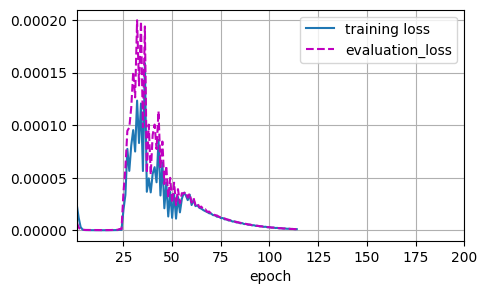

In [18]:
model.start_training(sequence=train_sequence.reshape(-1, 1),
                     loss=nn.MSELoss(),
                     metric=nn.MSELoss(),
                     epochs=200,
                     batch_size=32,
                     num_warmup_steps=100,
                     optimizer_params={'beta1':0.01, 'beta2': 0.01, 'epsilon': 0.1},
                     standardize=False,
                     verbose=True,
                     plot=True)

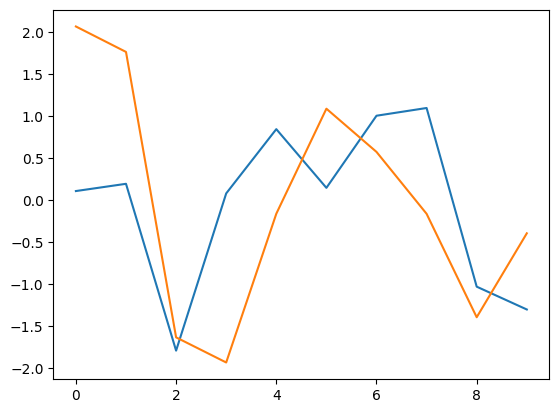

In [19]:
x = train_sequence[-10:].reshape(-1, 1)
y = test_sequence
y_hat = model.predict(x, False)
plt.plot(y)
plt.plot(y_hat)
plt.show()